In [1]:
# Only run once, unless restarting kernel
import os
os.chdir('../')
print(os.getcwd())  # Should output the project folder

/home/vlad/Desktop/lmu_bachelor_thesis/code/VariationalInformationPursuit


In [2]:
import torch
from arch.mutagenicity import QuerierMutagenicity, ClassifierMutagenicity

In [3]:
device = torch.device('cpu')

In [4]:
classifier = ClassifierMutagenicity(queryset_size=403)
querier = QuerierMutagenicity(queryset_size=403, tau=1.0)

In [5]:
PATH = './saved/y3fy898v/ckpt/epoch99.ckpt' 
ckpt = torch.load(PATH, weights_only=True, map_location=device)

Since the model was trained with nn.DataParallel, and we called model.state_dict() in torch.save() instead of model.module.state_dict(), we still have that "module." wrapper in from of the keys of the state_dict. Next time, save the state_dict correctly, but for now, we must remove the wrapper from the key names.

In [6]:
from collections import OrderedDict

# Classifier
state_dict = ckpt['classifier']
new_state_dict = OrderedDict()

for key, value in state_dict.items():
    # Remove the 'module.' prefix if it exists
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value

classifier.load_state_dict(new_state_dict)

# Querier
state_dict = ckpt['querier']
new_state_dict = OrderedDict()

for key, value in state_dict.items():
    # Remove the 'module.' prefix if it exists
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value

querier.load_state_dict(new_state_dict)

<All keys matched successfully>

In [7]:
classifier.eval()

ClassifierMutagenicity(
  (layer1): Linear(in_features=403, out_features=1000, bias=True)
  (layer2): Linear(in_features=1000, out_features=1000, bias=True)
  (classifier): Linear(in_features=1000, out_features=2, bias=True)
  (relu): ReLU()
)

In [8]:
querier.eval()

QuerierMutagenicity(
  (layer1): Linear(in_features=403, out_features=1000, bias=True)
  (layer2): Linear(in_features=1000, out_features=1000, bias=True)
  (classifier): Linear(in_features=1000, out_features=403, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=-1)
)

Load Mutagenicity dataset and queryset.

In [9]:
from dataset import load_mutagenicity_dataset, load_mutagenicity_queryset

dataset_root = './data/Mutagenicity'
queryset_root = './experiments/rdkit_querysets/queryset_1.csv'

dataset = load_mutagenicity_dataset(dataset_root)
queryset = load_mutagenicity_queryset(dataset_root, queryset_root, train_ratio=None)

/home/vlad/anaconda3/envs/vip_graphs/lib/python3.12/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1729805341246/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


Loading and processing Mutagenicity dataset for training...


100%|██████████| 4337/4337 [00:05<00:00, 853.29it/s]


Loading complete.


In [169]:
idx = 10
data = dataset[idx]
query_answer = queryset[idx]

print(data)
print(query_answer)

Data(edge_index=[2, 58], x=[28, 14], edge_attr=[58, 3], y=[1], atom=[28], bonds=[58], mutagenicity='mutagen', num_undirected_edges=29)
(tensor([ 1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,
        -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1,
        -1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
         1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1,
        -1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1,
         1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, 

In [170]:
import mutagenicity_utils
import numpy as np
import ops

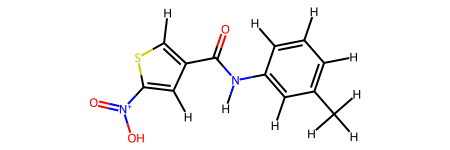

In [171]:
G = mutagenicity_utils.raw_to_nx(data)
mol = mutagenicity_utils.nx_to_rdkit(G)

mol

In [172]:
# cuda
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('DEVICE:', device)

# Vars
N_QUERIES = 403
max_queries_test = 20
THRESHOLD = 0.85

DEVICE: cpu


In [173]:
# epoch_test_qry_need = []
# epoch_test_acc_max = 0
# epoch_test_acc_ip = 0

test_features = query_answer[0].to(device)
test_labels = query_answer[1].to(device)

# test_features = test_features.to(device)
# test_labels = test_labels.to(device)
# test_bs = test_features.shape[0]

# Compute logits for all queries
mask = torch.zeros(1, N_QUERIES).to(device)
logits, queries = [], []
for i in range(max_queries_test):
    with torch.no_grad():
        query = querier(test_features * mask, mask)
        label_logits = classifier(test_features * (mask + query))

    mask[np.arange(1), query.argmax(dim=1)] = 1.0
    
    logits.append(label_logits)
    queries.append(query)   
logits = torch.stack(logits).permute(1, 0, 2)

# accuracy using all queries
test_pred_max = logits[:, -1, :].argmax(dim=1).float()
test_acc_max = (test_pred_max == test_labels.squeeze()).float().sum()

# compute number of queries needed for prediction
qry_need = ops.compute_queries_needed(logits, threshold=THRESHOLD)

# accuracy using IP
test_pred_ip = logits[torch.arange(len(qry_need)), qry_need-1].argmax(1)
test_acc_ip = (test_pred_ip == test_labels.squeeze()).float().sum()

In [174]:
import pandas as pd

def get_query_name_list():
    df = pd.read_csv('./experiments/rdkit_querysets/queryset_1.csv')
    frag_func_name = df['frag_func_name'].to_list()
    count_list = [eval(n) for n in df['count_list'].to_list()]

    query_names = []
    for frag, frag_counts in zip(frag_func_name, count_list):
        for count in frag_counts:
            name = f'{frag}={count}'
            query_names.append(name)
    return query_names

In [175]:
q_ans_pairs = []
for q in queries:
    q_idx = torch.argmax(q).item()
    q_name = get_query_name_list()[q_idx]
    q_ans = query_answer[0][q_idx].item()
    q_ans_pairs.append((q_name, q_ans))

In [176]:
q_ans_pairs

[('fr_COO=0', 1),
 ('fr_NH0=0', -1),
 ('fr_Ndealkylation2=0', 1),
 ('fr_nitroso=0', 1),
 ('fr_benzene=0', -1),
 ('fr_bicyclic=1', -1),
 ('fr_ArN=0', 1),
 ('fr_bicyclic=0', 1),
 ('fr_Ar_OH=0', 1),
 ('fr_ester=0', 1),
 ('fr_nitrile=0', 1),
 ('fr_benzene=1', 1),
 ('fr_sulfonamd=0', 1),
 ('fr_Al_COO=0', 1),
 ('fr_C_O_noCOO=0', -1),
 ('fr_benzene=4', -1),
 ('fr_alkyl_halide=0', 1),
 ('fr_Ar_N=0', 1),
 ('fr_halogen=0', 1),
 ('fr_C_O_noCOO=1', 1)]

In [177]:
all_frag_counts = mutagenicity_utils.onehot_to_interpretable_dict(query_answer[0])
frag_count_list = []
for frag, count in all_frag_counts.items():
    if count > 0:
        frag_count_list.append((frag, count))

In [178]:
frag_count_list

[('fr_C_O', 1),
 ('fr_C_O_noCOO', 1),
 ('fr_NH0', 1),
 ('fr_NH1', 1),
 ('fr_amide', 1),
 ('fr_aniline', 1),
 ('fr_benzene', 1),
 ('fr_thiophene', 1)]